# Assignment 2: Solving the Saleman Problem using Simulated Annealing

## Data Preparation

In [1]:
!curl https://raw.githubusercontent.com/hflabs/city/ae661bffe572880472249097c9b29c42b09650ea/city.csv > city.csv
! pip install scikit-learn # we will use it to calculate the distances between cities

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 24  316k   24 80577    0     0   169k      0  0:00:01 --:--:--  0:00:01  169k
100  316k  100  316k    0     0   552k      0 --:--:-- --:--:-- --:--:--  553k
ERROR: Invalid requirement: '#'

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import random
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from typing import List

# seed for reproducibility
random.seed(0) 
np.random.seed(0)
# read the csv file
org_df = pd.read_csv("city.csv")

# filter the top 30 cities by population
CITIES_DF = org_df.sort_values("population", ascending=False).iloc[:30, :][['address', 'geo_lat', 'geo_lon']].reset_index()
CITIES_DF

,index,address,geo_lat,geo_lon
0,509,г Москва,55.754047,37.620405
1,786,г Санкт-Петербург,59.939131,30.315900
2,647,г Новосибирск,55.028191,82.921149
3,832,г Екатеринбург,56.838522,60.605491
4,619,г Нижний Новгород,56.324063,44.005391
5,927,г Казань,55.794358,49.111497
6,782,г Самара,53.195031,50.106952
7,656,г Омск,54.984857,73.367452
8,1064,г Челябинск,55.160262,61.400808
9,757,г Ростов-на-Дону,47.222457,39.718803


In [3]:
# define a function to get all the attributes of a given city just by its name
def get_city_by_name(cities: pd.DataFrame, city_name: str) -> pd.Series:
  return cities[cities['address'] == city_name].iloc[0, :]    

Since the coordinates are geosdic, we need to use the Haversine formula to calculate the distance between 2 cities
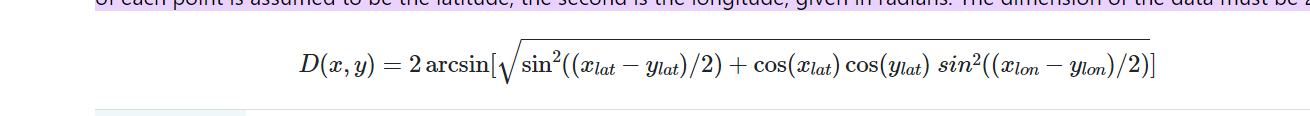

In [4]:
EARTH_RADIUS = 6371

def _distance_haversine(x_lat:float, x_lon:float, y_lat:float, y_lon:float, to_rad: bool = True):

	if to_rad:
		x_lat = np.deg2rad(x_lat)
		x_lon = np.deg2rad(x_lon)
		y_lat = np.deg2rad(y_lat)
		y_lon = np.deg2rad(y_lon)

	# calculate the distance
	dis = haversine_distances(np.asarray([[x_lat, x_lon], [y_lat, y_lon]]))
	return dis[0, 1]

def distance_cities(city1_name: str, city2_name: str):
	# get the information about the first city
	c1_info = get_city_by_name(cities=CITIES_DF, city_name=city1_name)
	c2_info = get_city_by_name(cities=CITIES_DF, city_name=city2_name)

	# return the distance using the formula and the earth radius
	return _distance_haversine(c1_info.geo_lat, c1_info.geo_lon, c2_info.geo_lat, c2_info.geo_lon) * EARTH_RADIUS

In [5]:
# let's verify the correctness of the formula really quick
distance_cities(city1_name="г Москва", city2_name="г Санкт-Петербург")
# the read distance between Moscow and Saint Peter is around 700k,sounds good so far.

634.4368333744881

In [6]:
# to accelerate the code a bit further, it might be worthy computing all the pairwise distances in advance
def prepare_pairwise_distances() -> pd.DataFrame:
	data = np.zeros(shape=(len(CITIES_DF), len(CITIES_DF)))
	cities = CITIES_DF['address'].tolist()
	for ci1, c1 in enumerate(cities):
		for ci2, c2 in enumerate(cities):
			if ci1 == ci2:
				data[ci1, ci1] = 0
			else:
				data[ci1, ci2] = distance_cities(c1, c2)
	return pd.DataFrame(data, columns=cities, index=cities)

CITY_DISTANCES = prepare_pairwise_distances()
CITY_DISTANCES.head()

,г Москва,г Санкт-Петербург,г Новосибирск,г Екатеринбург,г Нижний Новгород,г Казань,г Самара,г Омск,г Челябинск,г Ростов-на-Дону,...,г Ульяновск,г Владивосток,г Ярославль,г Иркутск,г Тюмень,г Махачкала,г Хабаровск,г Оренбург,"Кемеровская область - Кузбасс, г Новокузнецк",г Кемерово
г Москва,0.000000,634.436833,2810.788701,1416.596095,401.494336,717.868135,854.049900,2235.340549,1493.434253,959.613175,...,703.201124,6415.139362,249.894407,4201.554008,1710.166642,1586.415565,6139.951116,1226.479893,3119.865086,2981.906856
г Санкт-Петербург,634.436833,0.000000,3104.861583,1782.134249,896.321408,1198.155199,1417.372385,2583.977290,1909.261921,1540.747283,...,1251.203810,6536.708471,608.675375,4415.282841,2041.744653,2214.961849,6195.062862,1777.027179,3412.347016,3251.826397
г Новосибирск,2810.788701,3104.861583,0.000000,1398.047930,2411.592016,2114.620602,2128.757185,608.769148,1363.960697,3082.502815,...,2200.269981,3714.735509,2623.096194,1434.098408,1100.885375,2867.572946,3575.033860,1865.790830,309.774650,202.350688
г Екатеринбург,1416.596095,1782.134249,1398.047930,0.000000,1015.709920,717.385177,781.145267,820.271707,193.051821,1772.740869,...,817.376853,5064.479352,1244.481760,2810.765985,300.508189,1796.732737,4851.160492,665.032351,1705.865688,1576.171815
г Нижний Новгород,401.494336,896.321408,2411.592016,1015.709920,0.000000,322.354078,523.401634,1833.926900,1093.523753,1053.633625,...,355.831843,6036.004655,287.660768,3809.352379,1310.706754,1503.987531,5778.062990,880.983304,2720.311104,2584.788841


# Simulated Annealing: utility functions
Everything sounds good, let's proceed

In [7]:
# let's define some utility functions
def cities_random_permutation() -> List[str]:
	# extract all names
	city_names = list(CITIES_DF['address'])
	# shuffle
	random.shuffle(city_names)
	return city_names

def path_length(city_names_order: List[str]) -> float:
	# let's make it a closed path
	if city_names_order[-1] != city_names_order[0]:
		city_names_order = city_names_order + [city_names_order[0]] 	

	path_distance = 0
	for src, dst in zip(city_names_order, city_names_order[1:]):
		path_distance += CITY_DISTANCES.loc[src, dst].item()
		# path_distance += distance_cities(city1_name=src, city2_name=dst)
	return path_distance	

In [8]:
# this is the proposal distribution for the salesman problem !!
def propose_new_path(path: List[str]) -> List[str]:
	# this is done by switching 2 cities
	# select 2 city indices at random
	n = len(path)
	c_i1, c_i2 = random.randint(0, n - 1), random.randint(0, n - 2)
	# make sure the cities are different (otherwise what's the point ?)
	while c_i2 == c_i1:
		c_i2 = random.randint(0, n-1)

	new_path = []
	for city_index, city in enumerate(path):
		# if we find the first city, insert the 2nd one
		
		if city_index == c_i2:
			new_path.append(path[c_i1])
		elif city_index == c_i1: # insert the 1st one since we encountered the 2nd city
			new_path.append(path[c_i2])
		else:
			# otherwise insert the same city
			new_path.append(city)

	return new_path

In [9]:
def target_distribution(path: List[str], temperature: float) -> float:
	return np.exp(-path_length(path) / temperature)

def accept(threshold: float) -> bool:
	return random.uniform(0, 1) <= threshold 

def update_path(path: List[str], proposed_path: List[str], temperature: float) -> List [str]:
	alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
	if accept(alpha):
		return proposed_path
	else:
		return path
	
def update_temperature(T:float, cooling_factor:float) -> float:
	if not  (0 < cooling_factor < 1): 
		raise ValueError(f"The cooling factor does not belong to the [0, 1] range.")
	return cooling_factor * T

# Simulated Annealing: Best performance for each cooling factor

In [18]:
# let's put everything together now
def simulated_annealing(cooling_factor, 
						temp_update_per_iterations: int = 10,
						num_iterations: int = 10 ** 4, 
						display_per_iterations: int = 10 ** 3):
	random.seed(0) 
	np.random.seed(0)

	current_path = cities_random_permutation()

	temp = path_length(current_path) / 100

	paths = []
	distances = []

	for i in range(num_iterations):
		if i % display_per_iterations == 0:
			print("Current path length", path_length(current_path))
			print("Temp", temp)
			print("Iteration", i)
		
		paths.append(current_path)
		distances.append(path_length(current_path))
		proposed_path = propose_new_path(current_path)

		# update the path
		current_path = update_path(current_path, proposed_path, temp)	
		if i % temp_update_per_iterations == 0:
			temp = update_temperature(temp, cooling_factor)

		if temp <= 10 ** -6:
			# a temperature less than 10 ^ -6 could lead to unstable numerical operations
			break

	return paths, distances

paths_slow, distances_slow = simulated_annealing(0.9999, temp_update_per_iterations=1, num_iterations=2 * 10 ** 4)

Current path length 61078.260369463555
Temp 610.7826036946356
Iteration 0
Current path length 27818.103011079307
Temp 552.6561906362464
Iteration 1000
Current path length 28502.06591418865
Temp 500.0615001164439
Iteration 2000
Current path length 27247.455691978954
Temp 452.47209410759393
Iteration 3000
Current path length 22776.48993010261
Temp 409.4116341658728
Iteration 4000
Current path length 21573.68137524006
Temp 370.4491135988434
Iteration 5000
Current path length 26839.258474764236
Temp 335.19454337384445
Iteration 6000
Current path length 23266.829477080923
Temp 303.29504858599506
Iteration 7000
Current path length 22042.945520972142
Temp 274.43133641404927
Iteration 8000
Current path length 21049.291469494
Temp 248.31450021066607
Iteration 9000
Current path length 22612.148156973315
Temp 224.68312773816402
Iteration 10000
Current path length 20577.672712830226
Temp 203.30068460510975
Iteration 11000
Current path length 20624.312892504895
Temp 183.9531467136772
Iteration 1200

In [19]:
paths_middle, distances_middle = simulated_annealing(0.9975, temp_update_per_iterations=20, num_iterations=2 * 10 ** 4)

Current path length 61078.260369463555
Temp 610.7826036946356
Iteration 0
Current path length 29477.227124190475
Temp 538.9294009832322
Iteration 1000
Current path length 24894.693174200773
Temp 475.52909576539815
Iteration 2000
Current path length 25227.697010430744
Temp 419.5872789773679
Iteration 3000
Current path length 23783.85296501244
Temp 370.2265250378863
Iteration 4000
Current path length 24856.661898936698
Temp 326.67262977012666
Iteration 5000
Current path length 24205.102887400528
Temp 288.2424673110871
Iteration 6000
Current path length 22263.078914090907
Temp 254.33327554881953
Iteration 7000
Current path length 22354.35158469033
Temp 224.41320203375753
Iteration 8000
Current path length 22231.547799859425
Temp 198.01296208044621
Iteration 9000
Current path length 21894.505035685725
Temp 174.71847822025265
Iteration 10000
Current path length 20563.769083465537
Temp 154.1643855577443
Iteration 11000
Current path length 20043.01055849065
Temp 136.0283011647815
Iteration 12

In [20]:
paths_fast, distances_fast = simulated_annealing(0.995, temp_update_per_iterations=20, num_iterations=2 * 10 ** 4)

Current path length 61078.260369463555
Temp 610.7826036946356
Iteration 0
Current path length 27967.126191422187
Temp 475.3797700946146
Iteration 1000
Current path length 28123.17045210175
Temp 369.99404444104283
Iteration 2000
Current path length 24867.180076058667
Temp 287.97101082907693
Iteration 3000
Current path length 20365.439535534235
Temp 224.13145380002044
Iteration 4000
Current path length 20766.74082443084
Temp 174.44432492660604
Iteration 5000
Current path length 21470.85442492255
Temp 135.77220859973977
Iteration 6000
Current path length 20497.24914114143
Temp 105.6732148541205
Iteration 7000
Current path length 18767.669735821477
Temp 82.24679006677457
Iteration 8000
Current path length 18493.160131799796
Temp 64.01370948755908
Iteration 9000
Current path length 18424.810758796146
Temp 49.82267391871128
Iteration 10000
Current path length 18342.516459741237
Temp 38.7776127376693
Iteration 11000
Current path length 18227.437876136806
Temp 30.181102926872917
Iteration 1200

C:\Users\bouab\AppData\Local\Temp\ipykernel_15744\3619960694.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)


Current path length 18145.020520138103
Temp 23.490331394166336
Iteration 13000
Current path length 18145.020520138103
Temp 18.28281989378341
Iteration 14000
Current path length 18145.020520138103
Temp 14.229748301956004
Iteration 15000
Current path length 18145.020520138103
Temp 11.075191787338541
Iteration 16000
Current path length 18145.020520138103
Temp 8.619960840029082
Iteration 17000
Current path length 18145.020520138103
Temp 6.709023763234595
Iteration 18000
Current path length 18145.020520138103
Temp 5.2217174405974
Iteration 19000


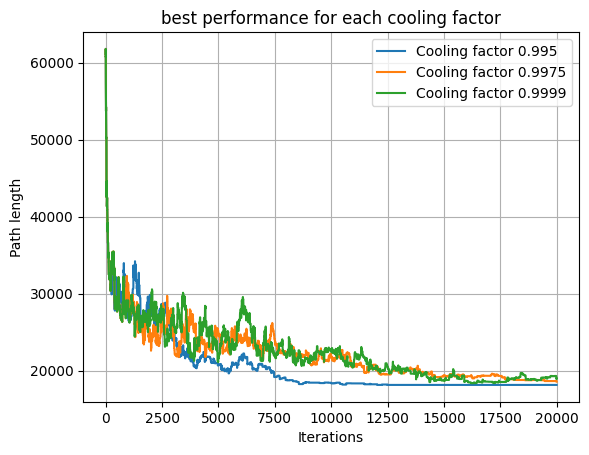

In [21]:
import matplotlib.pyplot as plt

plt.plot(distances_fast, label="Cooling factor 0.995")
plt.plot(distances_middle, label="Cooling factor 0.9975")
plt.plot(distances_slow, label="Cooling factor 0.9999")
plt.title("best performance for each cooling factor")
plt.legend()
plt.ylabel("Path length")
plt.xlabel("Iterations")
plt.grid()
plt.show()

Observations: 
1. Given enough iterations, the algorithm reaches close optima for different cooling factors
2. The fast cooling is both the fastest and the most stable. The lower the temperature, the more emphasis on exploitation rather than exploration. Mathematically, 

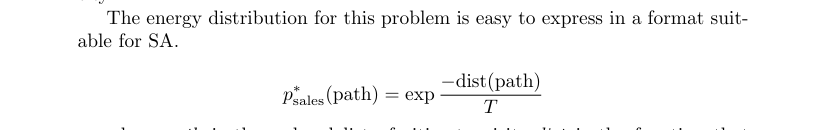

As T decreases linearly, the probability of the proposed solution decreases exponentially. In other words, if T decreases fast, the dominant factor is: $-dis(path)$ making the algorithm very unlikely to pick new proposed paths unless the new path is much better than the current one.  

These observations are futher confirmed from the plot as SA(0.995) stops exploring after the 7500-th iteration, while SA(0.9975) and SA(0.999) keep exploring even after the 15k-th iteration.

3. It is crucial to point that for cooling = 0.9975 and 0.995, I only update the temperature every 20 iterations to avoid numerical issues. 

It is possible to tune this hyper-parameter as a way to balance exploration and exploitation with low cooling factor.

# Fair comparison: Less iterations, update temperature every iteration

In [22]:
paths_slow, distances_slow = simulated_annealing(0.9999, temp_update_per_iterations=1, num_iterations=2500)

Current path length 61078.260369463555
Temp 610.7826036946356
Iteration 0
Current path length 27818.103011079307
Temp 552.6561906362464
Iteration 1000
Current path length 28502.06591418865
Temp 500.0615001164439
Iteration 2000


In [23]:
paths_middle, distances_middle = simulated_annealing(0.9975, temp_update_per_iterations=1, num_iterations=2500)

Current path length 61078.260369463555
Temp 610.7826036946356
Iteration 0
Current path length 23740.520398965295
Temp 49.9793976562942
Iteration 1000


C:\Users\bouab\AppData\Local\Temp\ipykernel_15744\3619960694.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)


Current path length 23579.481661185506
Temp 4.089736962015442
Iteration 2000


In [24]:
paths_fast, distances_fast = simulated_annealing(0.995, temp_update_per_iterations=1, num_iterations=2500)

Current path length 61078.260369463555
Temp 610.7826036946356
Iteration 0


C:\Users\bouab\AppData\Local\Temp\ipykernel_15744\3619960694.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)


Current path length 27466.598082646928
Temp 4.064128253481287
Iteration 1000
Current path length 27466.598082646928
Temp 0.02704258169900768
Iteration 2000


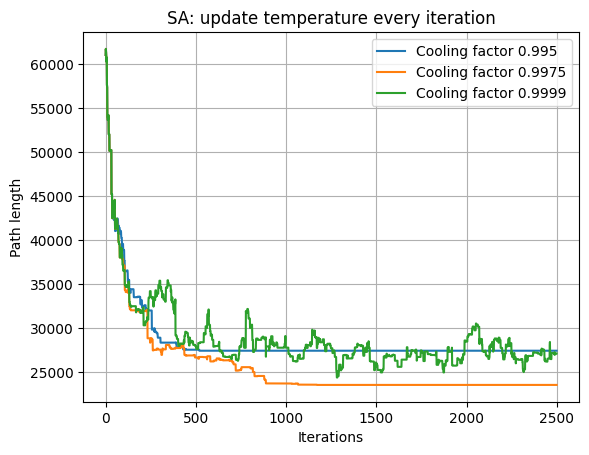

In [25]:
import matplotlib.pyplot as plt

plt.plot(distances_fast, label="Cooling factor 0.995")
plt.plot(distances_middle, label="Cooling factor 0.9975")
plt.plot(distances_slow, label="Cooling factor 0.9999")
plt.title("SA: update temperature every iteration")
plt.ylabel("Path length")
plt.xlabel("Iterations")
plt.legend()
plt.grid()
plt.show()

Rerunning the experiments with the given setting further confirms the above observations. A very low cooling factor leads both to stagnation as well as numerical issues. Choosing a larger cooling factor (to explore more), or updating the temperature less frequently are both valid approaches. However updating the temperature less frequently seems more scalable as it allows the algorithm to run for more iterations and hence finding better optima.  